In [98]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [99]:
def load_image_cv2(filepath: str):
    """Load image with cv2. Use with `albumentations`."""
    out = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)  # 2D; (H, W)
    return np.expand_dims(out, axis=2)  # 3D; (H, W, 1)

In [100]:
image = load_image_cv2('data/wm811k/labeled/test/center/000604.png')

In [101]:
image.shape

(26, 26, 1)

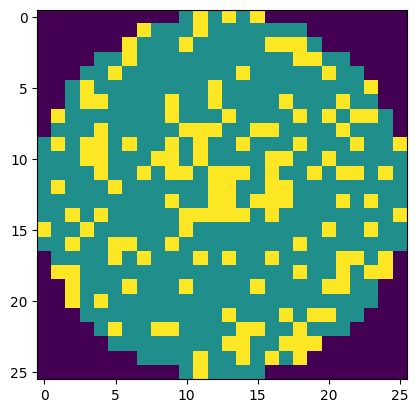

In [102]:
plt.imshow(np.array(image))

In [103]:
import albumentations as A
from torch.distributions import Bernoulli
from albumentations.core.transforms_interface import BasicTransform
from albumentations.core.transforms_interface import ImageOnlyTransform
import torch

class ToWBM(BasicTransform):
    def __init__(self, always_apply: bool = True, p: float = 1.0):
        super(ToWBM, self).__init__(always_apply, p)

    @property
    def targets(self):
        return {"image": self.apply}

    def apply(self, img: np.ndarray, **kwargs):  # pylint: disable=unused-argument
        if isinstance(img, np.ndarray):
            if img.ndim == 2:
                img = img[:, :, None]
            # img = torch.from_numpy(img.transpose(2, 0, 1))
            img = torch.from_numpy(img)
            if isinstance(img, torch.ByteTensor):
                img = img.float().div(255)
        return torch.ceil(img * 2)

    def get_transform_init_args_names(self):
        return []

    def get_params_dependent_on_targets(self, params):
        return {}

class MaskedBernoulliNoise(ImageOnlyTransform):
    def __init__(self, noise: float, always_apply: bool = False, p: float = 1.0):
        super(MaskedBernoulliNoise, self).__init__(always_apply, p)
        self.noise = noise
        self.min_ = 0
        self.max_ = 1
        self.bernoulli = Bernoulli(probs=noise)

    def apply(self, x: torch.Tensor, **kwargs):  # pylint: disable=unused-argument
        assert x.ndim == 3
        m = self.bernoulli.sample(x.size()).to(x.device)
        m = m * x.gt(0).float()
        noise_value = 1 + torch.randint_like(x, self.min_, self.max_ + 1).to(x.device)  # 1 or 2
        return x * (1 - m) + noise_value * m

    def get_params(self):
        return {'noise': self.noise}

In [109]:
class WM811KTransformMultiple(object):
    """Transformations for wafer bin maps from WM-811K."""
    def __init__(self,
                 *hyperparams
                 ):
        transforms = []
        size = (26, 26)
        resize_transform = A.Resize(*size, interpolation=cv2.INTER_NEAREST)
        wbm_transform = ToWBM()

        transforms.append(resize_transform)
        transforms.append(wbm_transform)
        print(f'start {len(hyperparams)-1} --> {hyperparams}')

        for i in range(0, len(hyperparams)-1, 4):
            print('start...', i)
            mode, magnitude = hyperparams[i], hyperparams[i+1] #, hyperparams[i+2], hyperparams[i+3]

            if mode == 'crop':
                print('crop')
                # scale = (magnitude, magnitude + 0.5)  # 0.1 < magnitude < 0.5
                # ratio = (0.9, 1.1)
                transforms.append(A.RandomResizedCrop(*size, interpolation=cv2.INTER_NEAREST, p=magnitude),)
            elif mode == 'cutout':
                print('cutout')
                cut_ratio = magnitude  # 0.2 = magnitude
                num_holes: int = 4
                # cut_ratio: float = 0.2
                cut_h = int(size[0] * cut_ratio)
                cut_w = int(size[1] * cut_ratio)
                transforms.append(A.Cutout(num_holes=num_holes, max_h_size=cut_h, max_w_size=cut_w, fill_value=0, p=0.5))
            elif mode == 'noise':
                print('noise')
                noise = magnitude
                # noise: float = 0.05
                transforms.append(MaskedBernoulliNoise(noise=noise))
            elif mode == 'rotate':
                print('rotate')
                limit = magnitude  # 180 (angle)
                transforms.append(A.Rotate(limit=limit, interpolation=cv2.INTER_NEAREST, border_mode=cv2.BORDER_CONSTANT, p=1.0),)
            elif mode == 'shift':
                print('shift')
                shift = magnitude  # 0.25
                transforms.append( A.ShiftScaleRotate(
                shift_limit=shift,
                scale_limit=0,
                rotate_limit=0,
                interpolation=cv2.INTER_NEAREST,
                border_mode=cv2.BORDER_CONSTANT,
                value=0,
                p=1.0
            ),)
            elif mode == 'test':
                pass




        self.transform = A.Compose(transforms)

    def __call__(self, img):
        return self.transform(image=img)['image']

In [110]:
# hyperparams = ['rotate', 0.8009107519796445, 'rotate', 0.6788795301189604, 'rotate', 0.5820197920751072, 'rotate', 0.7586156243223574, 'rotate', 0.47360041934665753, 'rotate', 0.7369181771289582, 'rotate', 0.13521817340545209, 'rotate', 0.1496748671836832, 'rotate', 0.38648898112586205, 'rotate', 0.4499499899112277]

# rotate

start 4 --> ('crop', 0.2, 'rotate', 0.3, 1.0)
start... 0
crop


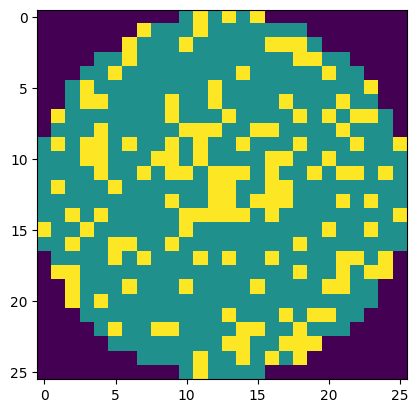

In [134]:
hyperparams = ['crop', 0.2, 'rotate', 0.3, 1.0]
transform = WM811KTransformMultiple(*hyperparams)
plt.imshow(transform(image))

start 4 --> ('cutout', 0.2, 'rotate', 0.3, 1.0)
start... 0
cutout


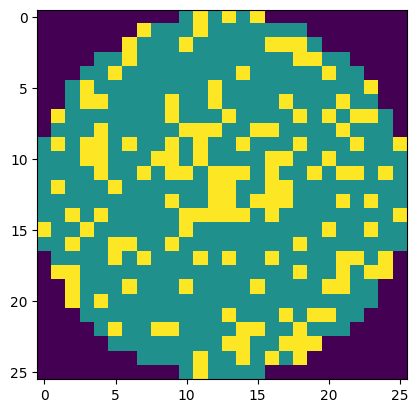

In [135]:
hyperparams = ['cutout', 0.2, 'rotate', 0.3, 1.0]
transform = WM811KTransformMultiple(*hyperparams)
plt.imshow(transform(image))

start 4 --> ('noise', 0.2, 'rotate', 0.3, 1.0)
start... 0
noise


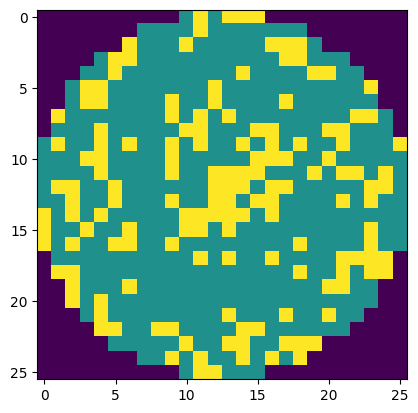

In [136]:
hyperparams = ['noise', 0.2, 'rotate', 0.3, 1.0]
transform = WM811KTransformMultiple(*hyperparams)
plt.imshow(transform(image))

In [137]:
hyperparams = ['shift', 0.2, 'rotate', 0.3, 1.0]
transform = WM811KTransformMultiple(*hyperparams)
plt.imshow(transform(image))

start 4 --> ('shift', 0.2, 'rotate', 0.3, 1.0)
start... 0
shift


error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'warpAffine'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [138]:
hyperparams = ['rotate', 0.2, 'rotate', 0.3, 1.0]
transform = WM811KTransformMultiple(*hyperparams)
plt.imshow(transform(image))

start 4 --> ('rotate', 0.2, 'rotate', 0.3, 1.0)
start... 0
rotate


error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'warpAffine'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'
